# Bài 6 Áp dụng GAN trên tập MIST

## a) Sử dụng torch để xây mô hình GAN 

In [1]:
# gan_mnist_cuda.py
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

In [2]:

# ====== cấu hình ======
latent_dim = 100
batch_size = 128
epochs = 20
lr = 2e-4
beta1, beta2 = 0.5, 0.999
img_size = 28

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
os.makedirs("samples", exist_ok=True)

In [3]:

# ====== dataset & loader ======
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),   # đưa về [-1, 1]
])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# ====== kiến trúc ======
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(True),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 7 -> 14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),    # 14 -> 28
            nn.Tanh(),  # output in [-1,1]
        )

    def forward(self, z):
        x = self.net(z)
        x = x.view(z.size(0), 256, 7, 7)
        x = self.conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),   # 28 -> 14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 14 -> 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.cls = nn.Linear(128 * 7 * 7, 1)  # logits

    def forward(self, x):
        h = self.net(x)
        h = h.view(x.size(0), -1)
        logits = self.cls(h)  # no sigmoid (dùng BCEWithLogitsLoss)
        return logits

G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.35MB/s]


## b) Train

In [4]:

# ====== loss & optimizers ======
criterion = nn.BCEWithLogitsLoss()
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

# noise cố định để log ảnh mẫu
fixed_z = torch.randn(64, latent_dim, device=device)

def save_samples(step, fake_imgs):
    # từ [-1,1] -> lưu lưới ảnh 8x8
    utils.save_image(fake_imgs, f"/kaggle/working/samples/step_{step:06d}.png",
                     nrow=8, normalize=True, value_range=(-1, 1))

# ====== vòng lặp train ======
global_step = 0
for epoch in range(1, epochs + 1):
    for real, _ in loader:
        real = real.to(device, non_blocking=True)
        b = real.size(0)

        # ------- train Discriminator -------
        z = torch.randn(b, latent_dim, device=device)
        with torch.no_grad():
            fake = G(z)

        D_real = D(real)
        D_fake = D(fake)

        # nhãn: real=1, fake=0
        real_targets = torch.ones(b, 1, device=device)
        fake_targets = torch.zeros(b, 1, device=device)

        loss_D_real = criterion(D_real, real_targets)
        loss_D_fake = criterion(D_fake, fake_targets)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad(set_to_none=True)
        loss_D.backward()
        opt_D.step()

        # ------- train Generator -------
        z = torch.randn(b, latent_dim, device=device)
        gen_imgs = G(z)
        D_gen = D(gen_imgs)

        # G muốn D đoán là "real" (1)
        loss_G = criterion(D_gen, real_targets)

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

        # log mẫu ảnh định kỳ
        if global_step % 300 == 0:
            with torch.no_grad():
                samples = G(fixed_z)
            save_samples(global_step, samples)

        if global_step % 100 == 0:
            print(f"step {global_step:6d} | epoch {epoch:02d}/{epochs} "
                  f"| D: {loss_D.item():.3f} | G: {loss_G.item():.3f}")
        global_step += 1

    # lưu checkpoint cuối mỗi epoch
    torch.save({
        "G": G.state_dict(),
        "D": D.state_dict(),
        "opt_G": opt_G.state_dict(),
        "opt_D": opt_D.state_dict(),
        "epoch": epoch,
    }, f"ckpt_epoch_{epoch:02d}.pt")

print("Đã train xong! Ảnh mẫu nằm trong thư mục ./samples")

step      0 | epoch 01/20 | D: 1.334 | G: 0.909
step    100 | epoch 01/20 | D: 0.025 | G: 4.867
step    200 | epoch 01/20 | D: 0.018 | G: 4.817
step    300 | epoch 01/20 | D: 0.558 | G: 1.441
step    400 | epoch 01/20 | D: 0.634 | G: 1.652
step    500 | epoch 02/20 | D: 0.335 | G: 1.882
step    600 | epoch 02/20 | D: 0.346 | G: 2.097
step    700 | epoch 02/20 | D: 0.239 | G: 2.306
step    800 | epoch 02/20 | D: 0.211 | G: 2.222
step    900 | epoch 02/20 | D: 0.285 | G: 2.700
step   1000 | epoch 03/20 | D: 0.205 | G: 2.939
step   1100 | epoch 03/20 | D: 0.198 | G: 2.365
step   1200 | epoch 03/20 | D: 0.246 | G: 3.822
step   1300 | epoch 03/20 | D: 0.502 | G: 4.191
step   1400 | epoch 03/20 | D: 0.195 | G: 3.604
step   1500 | epoch 04/20 | D: 0.218 | G: 3.106
step   1600 | epoch 04/20 | D: 0.229 | G: 3.432
step   1700 | epoch 04/20 | D: 0.410 | G: 1.318
step   1800 | epoch 04/20 | D: 0.226 | G: 2.806
step   1900 | epoch 05/20 | D: 0.339 | G: 2.234
step   2000 | epoch 05/20 | D: 0.230 | G

## C) Tinh chỉnh superparameter

In [6]:
# gan_mnist_train.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

# ========================
# Config (chỉnh ở đây thôi)
# ========================
latent_dim = 128       # vector noise
batch_size = 64        # batch size
epochs = 30            # số epoch
lr = 1e-4              # learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("samples", exist_ok=True)
print("Using device:", device)

# ========================
# Dataset
# ========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ========================
# Mô hình
# ========================
class Generator(nn.Module):
    def __init__(self, z_dim=latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256*7*7),
            nn.BatchNorm1d(256*7*7),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )
    def forward(self, x):
        return self.net(x)

G = Generator().to(device)
D = Discriminator().to(device)

# ========================
# Loss + Optimizer
# ========================
criterion = nn.BCEWithLogitsLoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_z = torch.randn(64, latent_dim, device=device)

def save_samples(epoch, G, fixed_z):
    with torch.no_grad():
        fake = G(fixed_z).detach().cpu()
    utils.save_image(fake, f"/kaggle/working/samples/epoch_{epoch:03d}.png", nrow=8, normalize=True, value_range=(-1,1))

# ========================
# Training Loop
# ========================
for epoch in range(1, epochs+1):
    for real, _ in loader:
        real = real.to(device)
        b = real.size(0)

        # Train Discriminator
        z = torch.randn(b, latent_dim, device=device)
        fake = G(z)

        real_labels = torch.ones(b, 1, device=device)
        fake_labels = torch.zeros(b, 1, device=device)

        loss_D_real = criterion(D(real), real_labels)
        loss_D_fake = criterion(D(fake.detach()), fake_labels)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(b, latent_dim, device=device)
        gen_imgs = G(z)
        output = D(gen_imgs)
        loss_G = criterion(output, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"[Epoch {epoch}/{epochs}] Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")
    save_samples(epoch, G, fixed_z)

    torch.save({"G": G.state_dict(),
                "D": D.state_dict(),
                "opt_G": opt_G.state_dict(),
                "opt_D": opt_D.state_dict(),
                "epoch": epoch}, f"ckpt_epoch_{epoch:02d}.pt")

print("Đã train xong! Ảnh mẫu nằm trong thư mục ./samples")


Using device: cuda
[Epoch 1/30] Loss_D: 0.3271 | Loss_G: 1.7671
[Epoch 2/30] Loss_D: 0.1619 | Loss_G: 3.9733
[Epoch 3/30] Loss_D: 0.1074 | Loss_G: 3.0627
[Epoch 4/30] Loss_D: 0.0921 | Loss_G: 2.3977
[Epoch 5/30] Loss_D: 0.0752 | Loss_G: 2.6259
[Epoch 6/30] Loss_D: 0.1230 | Loss_G: 2.7595
[Epoch 7/30] Loss_D: 0.1863 | Loss_G: 4.3773
[Epoch 8/30] Loss_D: 0.2463 | Loss_G: 3.1489
[Epoch 9/30] Loss_D: 0.1557 | Loss_G: 3.5113
[Epoch 10/30] Loss_D: 0.1434 | Loss_G: 3.3896
[Epoch 11/30] Loss_D: 0.2278 | Loss_G: 3.2220
[Epoch 12/30] Loss_D: 0.0797 | Loss_G: 2.4140
[Epoch 13/30] Loss_D: 0.1655 | Loss_G: 4.1993
[Epoch 14/30] Loss_D: 0.1559 | Loss_G: 3.7194
[Epoch 15/30] Loss_D: 0.2079 | Loss_G: 5.4664
[Epoch 16/30] Loss_D: 0.1708 | Loss_G: 2.5711
[Epoch 17/30] Loss_D: 0.2463 | Loss_G: 3.2004
[Epoch 18/30] Loss_D: 0.2211 | Loss_G: 3.5502
[Epoch 19/30] Loss_D: 0.1222 | Loss_G: 4.6277
[Epoch 20/30] Loss_D: 0.1503 | Loss_G: 4.6314
[Epoch 21/30] Loss_D: 0.2000 | Loss_G: 2.5499
[Epoch 22/30] Loss_D: 0.

## Triển khai so sánh một số biến thể GAN

In [7]:
import os, math, argparse, csv, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

# -----------------------------
# Utils
# -----------------------------
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, 'bias', None) is not None:
            nn.init.zeros_(m.bias.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.zeros_(m.bias.data)

def save_grid(tensor, path, nrow=8):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    vutils.save_image(tensor, path, nrow=nrow, normalize=True, value_range=(-1,1))

def make_noise(bs, nz, device):
    return torch.randn(bs, nz, 1, 1, device=device)


In [8]:
# -----------------------------
# DCGAN blocks for 28x28
# -----------------------------
class G28(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1):
        super().__init__()
        self.main = nn.Sequential(
            # (nz,1,1) -> (ngf*4, 7,7)
            nn.ConvTranspose2d(nz, ngf*4, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),

            # (ngf*4,7,7) -> (ngf*2, 14,14)
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),

            # (ngf*2,14,14) -> (ngf, 28,28)
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),

            # refine giữ 28×28
            nn.Conv2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z)


class D28(nn.Module):
    """Discriminator cho DCGAN (có Sigmoid). Với WGAN-GP sẽ dùng bản không Sigmoid."""
    def __init__(self, ndf=64, nc=1):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, True),
        )
        self.out = nn.Conv2d(ndf*4, 1, 3, 1, 0, bias=False)
    def forward(self, x):
        h = self.main(x)
        logits = self.out(h).view(x.size(0), -1)
        return torch.sigmoid(logits), logits

class DWasserstein(nn.Module):
    """Critic cho WGAN/WGAN-GP (KHÔNG Sigmoid)."""
    def __init__(self, ndf=64, nc=1):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1), nn.InstanceNorm2d(ndf*2, affine=True), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1), nn.InstanceNorm2d(ndf*4, affine=True), nn.LeakyReLU(0.2, True),
        )
        self.out = nn.Conv2d(ndf*4, 1, 3, 1, 0)
    def forward(self, x):
        return self.out(self.main(x)).view(x.size(0), -1)

In [9]:
# -----------------------------
# CGAN wrappers (label conditioning)
# -----------------------------
class CGAN_G(nn.Module):
    """Điều kiện thông qua concat one-hot vào kênh của z (emb -> (C,H,W) rồi concat)."""
    def __init__(self, nz=100, num_classes=10, ngf=64):
        super().__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.embed = nn.Embedding(num_classes, nz)
        self.g = G28(nz=nz*2, ngf=ngf, nc=1)
    def forward(self, z, y):
        e = self.embed(y).view(z.size(0), -1, 1, 1)
        zc = torch.cat([z, e], dim=1)
        return self.g(zc)

class CGAN_D(nn.Module):
    """Thêm điều kiện nhãn bằng cách concat 1 map (num_classes->1 channel) vào ảnh."""
    def __init__(self, num_classes=10, ndf=64):
        super().__init__()
        self.num_classes = num_classes
        self.embed = nn.Embedding(num_classes, 28*28)
        self.d = D28(ndf=ndf, nc=2)  # ảnh (1) + mask nhãn (1) = 2 kênh
    def forward(self, x, y):
        b, _, h, w = x.shape
        mask = self.embed(y).view(b, 1, 28, 28)
        if (h, w) != (28, 28):
            mask = F.interpolate(mask, size=(h, w), mode="nearest")
        return self.d(torch.cat([x, mask], dim=1))

In [10]:
# -----------------------------
# Gradient penalty cho WGAN-GP
# -----------------------------
def gradient_penalty(critic, real, fake, device):
    bs = real.size(0)
    eps = torch.rand(bs, 1, 1, 1, device=device)
    interp = (eps*real + (1-eps)*fake).requires_grad_(True)
    score = critic(interp)
    grad = autograd.grad(outputs=score, inputs=interp,
                         grad_outputs=torch.ones_like(score),
                         create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad = grad.view(bs, -1)
    gp = ((grad.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

In [11]:
# -----------------------------
# Training
# -----------------------------
def get_data_loader(batch_size):
    tfm = transforms.Compose([
        transforms.Resize(28),                 # thêm dòng này nếu trước đó có resize/crop
        transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
    ])
    ds = datasets.MNIST(root='./data', train=True, download=True, transform=tfm)
    return DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

@torch.no_grad()
def sample_and_save(G, fixed_z, device, out_dir, epoch, y_fixed=None, model='dcgan'):
    G.eval()
    if y_fixed is not None:
        imgs = G(fixed_z, y_fixed.to(device)).cpu()
    else:
        imgs = G(fixed_z).cpu()
    save_grid(imgs, f"{out_dir}/epoch_{epoch:03d}.png", nrow=8)
    G.train()

def train(args):
    device = torch.device('cuda' if torch.cuda.is_available() and not args.cpu else 'cpu')
    torch.manual_seed(args.seed); random.seed(args.seed)

    loader = get_data_loader(args.batch_size)

    nz = args.nz
    os.makedirs(f"samples/{args.model}", exist_ok=True)
    os.makedirs("logs", exist_ok=True)

    if args.model == 'dcgan':
        G = G28(nz=nz).to(device); D = D28().to(device)
        G.apply(weights_init_normal); D.apply(weights_init_normal)
        optG = torch.optim.Adam(G.parameters(), lr=args.lr, betas=(0.5, 0.999))
        optD = torch.optim.Adam(D.parameters(), lr=args.lr, betas=(0.5, 0.999))
        criterion = nn.BCELoss()
        fixed_z = make_noise(64, nz, device)
        y_fixed = None

    elif args.model == 'cgan':
        G = CGAN_G(nz=nz).to(device); D = CGAN_D().to(device)
        G.apply(weights_init_normal); D.apply(weights_init_normal)
        optG = torch.optim.Adam(G.parameters(), lr=args.lr, betas=(0.5, 0.999))
        optD = torch.optim.Adam(D.parameters(), lr=args.lr, betas=(0.5, 0.999))
        criterion = nn.BCELoss()
        fixed_z = make_noise(64, nz, device)
        # tạo nhãn 0..9 lặp lại đều nhau để xem đủ các lớp
        y_fixed = torch.arange(0, 10, device=device).repeat_interleave(7)
        y_fixed = torch.cat([y_fixed, torch.tensor([0,1,2,3], device=device)])[:64]

    elif args.model in ['wgan', 'wgan-gp']:
        G = G28(nz=nz).to(device); D = DWasserstein().to(device)
        G.apply(weights_init_normal); D.apply(weights_init_normal)
        optG = torch.optim.Adam(G.parameters(), lr=args.lr, betas=(0.0, 0.9))
        optD = torch.optim.Adam(D.parameters(), lr=args.lr, betas=(0.0, 0.9))
        fixed_z = make_noise(64, nz, device)
        y_fixed = None
    else:
        raise ValueError("model must be one of: dcgan, cgan, wgan, wgan-gp")

    # logging
    log_path = f"logs/{args.model}.csv"
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f); 
        if args.model in ['dcgan', 'cgan']:
            writer.writerow(['epoch','iter','D_loss','G_loss'])
        else:
            writer.writerow(['epoch','iter','D_wasserstein','GP','G_loss'])

    step = 0
    for epoch in range(1, args.epochs+1):
        for i, (imgs, labels) in enumerate(loader, 1):
            bs = imgs.size(0)
            real = imgs.to(device)

            # ------------------ Train D / Critic ------------------
            if args.model in ['dcgan', 'cgan']:
                D.zero_grad()
                valid = torch.ones(bs, 1, device=device)
                fake_lbl = torch.zeros(bs, 1, device=device)
                # real
                if args.model == 'dcgan':
                    pred_real, _ = D(real)
                else:
                    pred_real, _ = D(real, labels.to(device))
                d_real = criterion(pred_real, valid)
                # fake
                z = make_noise(bs, nz, device)
                if args.model == 'dcgan':
                    fake = G(z).detach()
                    pred_fake, _ = D(fake)
                else:
                    y = labels.to(device)
                    fake = G(z, y).detach()
                    pred_fake, _ = D(fake, y)
                d_fake = criterion(pred_fake, fake_lbl)
                d_loss = d_real + d_fake
                d_loss.backward(); optD.step()

                # ------------------ Train G ------------------
                G.zero_grad()
                z = make_noise(bs, nz, device)
                if args.model == 'dcgan':
                    gen = G(z)
                    pred, _ = D(gen)
                else:
                    y = labels.to(device)
                    gen = G(z, y)
                    pred, _ = D(gen, y)
                g_loss = criterion(pred, valid)
                g_loss.backward(); optG.step()

                with open(log_path, 'a', newline='') as f:
                    csv.writer(f).writerow([epoch, step, float(d_loss), float(g_loss)])

            else:
                # WGAN(-GP)
                for _ in range(args.n_critic):
                    D.zero_grad()
                    z = make_noise(bs, nz, device)
                    fake = G(z).detach()
                    d_real = D(real).mean()
                    d_fake = D(fake).mean()
                    wasserstein = d_fake - d_real
                    if args.model == 'wgan-gp':
                        gp = gradient_penalty(D, real, fake, device)
                        d_loss = wasserstein + args.lambda_gp * gp
                        gp_val = float(gp)
                    else:
                        d_loss = wasserstein
                        gp_val = 0.0
                    d_loss.backward(); optD.step()

                # G
                G.zero_grad()
                z = make_noise(bs, nz, device)
                fake = G(z)
                g_loss = -D(fake).mean()
                g_loss.backward(); optG.step()

                with open(log_path, 'a', newline='') as f:
                    csv.writer(f).writerow([epoch, step, float(-wasserstein), gp_val, float(g_loss)])

            step += 1

        # save samples
        if args.model == 'cgan':
            sample_and_save(G, fixed_z, device, f"/kaggle/working/model/{args.model}", epoch, y_fixed=y_fixed, model='cgan')
        else:
            sample_and_save(G, fixed_z, device, f"/kaggle/working/model/{args.model}", epoch)

        print(f"[{args.model}] Epoch {epoch}/{args.epochs} done.")

    print(f"Done. Samples in samples/{args.model} ; logs at {log_path}")


In [12]:
for model in ["dcgan", "cgan", "wgan", "wgan-gp"]:
    class Args:
        model = model    # hoặc "cgan", "wgan", "wgan-gp"
        epochs = 5
        batch_size = 128
        nz = 100
        lr = 2e-4
        n_critic = 5
        lambda_gp = 10.0
        cpu = False
        seed = 1337
    args = Args()
    train(args)
    print("=============================DONE=======================")
              

[dcgan] Epoch 1/5 done.
[dcgan] Epoch 2/5 done.
[dcgan] Epoch 3/5 done.
[dcgan] Epoch 4/5 done.
[dcgan] Epoch 5/5 done.
Done. Samples in samples/dcgan ; logs at logs/dcgan.csv
=============================DONE=======================
[cgan] Epoch 1/5 done.
[cgan] Epoch 2/5 done.
[cgan] Epoch 3/5 done.
[cgan] Epoch 4/5 done.
[cgan] Epoch 5/5 done.
Done. Samples in samples/cgan ; logs at logs/cgan.csv
=============================DONE=======================
[wgan] Epoch 1/5 done.
[wgan] Epoch 2/5 done.
[wgan] Epoch 3/5 done.
[wgan] Epoch 4/5 done.
[wgan] Epoch 5/5 done.
Done. Samples in samples/wgan ; logs at logs/wgan.csv
=============================DONE=======================
[wgan-gp] Epoch 1/5 done.
[wgan-gp] Epoch 2/5 done.
[wgan-gp] Epoch 3/5 done.
[wgan-gp] Epoch 4/5 done.
[wgan-gp] Epoch 5/5 done.
Done. Samples in samples/wgan-gp ; logs at logs/wgan-gp.csv
=============================DONE=======================


Đọc thành công: logs/dcgan.csv, 2340 dòng
Đọc thành công: logs/cgan.csv, 2340 dòng
Đọc thành công: logs/wgan-gp.csv, 2340 dòng


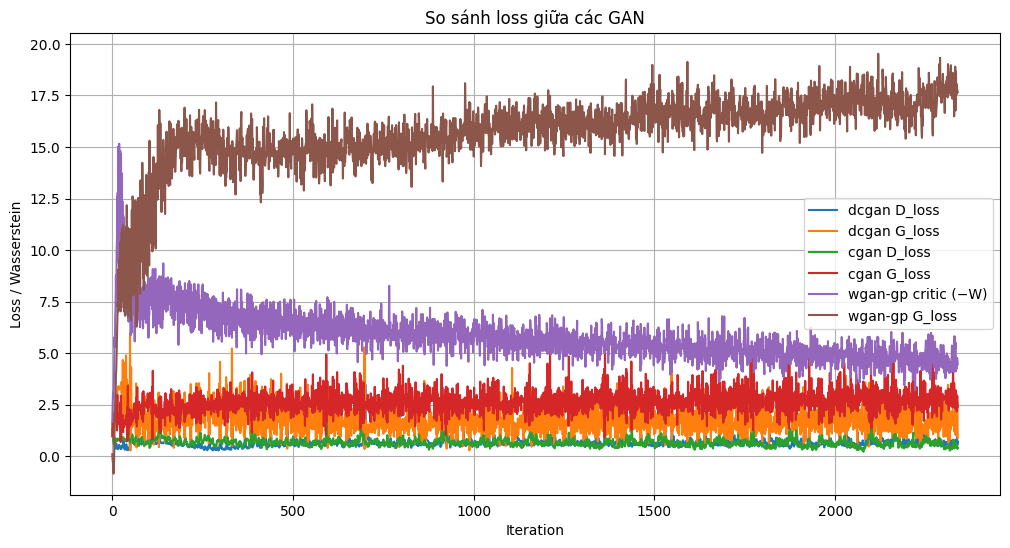

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Danh sách các model cần so sánh
models = ["dcgan", "cgan", "wgan-gp"]

logs = {}
for m in models:
    try:
        logs[m] = pd.read_csv(f"logs/{m}.csv")
        print(f"Đọc thành công: logs/{m}.csv, {len(logs[m])} dòng")
    except FileNotFoundError:
        print(f"⚠️ Chưa thấy {m}. Hãy train model này trước.")

# Vẽ loss
plt.figure(figsize=(12,6))

# Với DCGAN/CGAN: có D_loss và G_loss
for m in ["dcgan", "cgan"]:
    if m in logs:
        plt.plot(logs[m].iter, logs[m].D_loss, label=f"{m} D_loss")
        plt.plot(logs[m].iter, logs[m].G_loss, label=f"{m} G_loss")

# Với WGAN-GP: có D_wasserstein (giá trị critic), GP, G_loss
if "wgan-gp" in logs:
    plt.plot(logs["wgan-gp"].iter, logs["wgan-gp"].D_wasserstein, label="wgan-gp critic (−W)")
    plt.plot(logs["wgan-gp"].iter, logs["wgan-gp"].G_loss, label="wgan-gp G_loss")

plt.xlabel("Iteration")
plt.ylabel("Loss / Wasserstein")
plt.title("So sánh loss giữa các GAN")
plt.legend()
plt.grid(True)
plt.show()


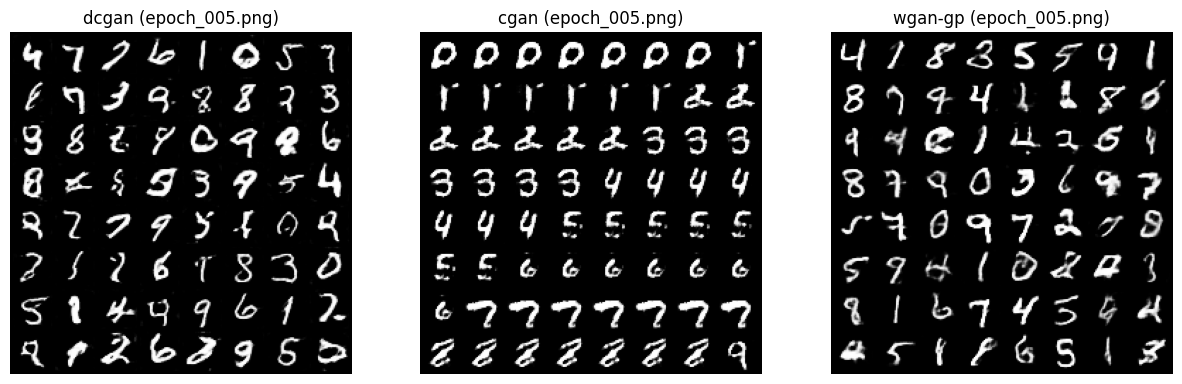

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import os

fig, axs = plt.subplots(1, len(models), figsize=(15,5))

for i, m in enumerate(models):
    folder = f"/kaggle/working/model/{m}"
    if not os.path.exists(folder):
        axs[i].set_title(f"{m} chưa có ảnh")
        axs[i].axis("off")
        continue
    
    files = sorted(os.listdir(folder))
    if not files:
        axs[i].set_title(f"{m} chưa có file")
        axs[i].axis("off")
        continue

    latest = files[-1]  # lấy file cuối cùng
    img = Image.open(os.path.join(folder, latest))
    axs[i].imshow(img)
    axs[i].set_title(f"{m} ({latest})")
    axs[i].axis("off")

plt.show()
